# Implementing a toy language : interpreter and compiler



In order to decompose the interpreter and compiler building process as much as
possible, we will decompose our task into a number of "languages" with increasing capabilities :
1. **const** : only one numerical constant (of integral type).
2. **addsub** : additions and subtraction.
3. **addmult** : additions, subtractions, multiplications and division, with priorities
4. **arith** : same as *addmult*, with parenthesis.
5. **lang0** : any number of expressions that can be either arithmetic expressions for the *arith* language or assignment of the result of such an expression into a variable. Expressions can also use variables. The code returns the value of the last expression.
6. **lang1** : same as *lang0* with arguments written as `%0`, `%1`,…

For each of these languages we will provide two execution models :
1. *interpretation* : the code is turned into a function that evaluates the AST when called.
2. *compilation* : the code is turned into a function that calls a static method from a dynamically compiled class.


First getting the dependencies from maven (might take some time, so one has to wait until the final output before going further).

In [1]:
%classpath add mvn rhizome rhizome 0.2.9
%classpath add mvn instaparse instaparse 1.4.9

;; with leiningen one would have a project.clj with
;;
;;(defproject languages "0.1.0-SNAPSHOT"
;;  :description "FIXME: write description"
;;  :url "http://example.com/FIXME"
;;  :license {:name "Eclipse Public License"
;;            :url "http://www.eclipse.org/legal/epl-v10.html"}
;;  :dependencies [[org.clojure/clojure "1.8.0"]
;;                 [instaparse "1.4.9"]
;;                 [rhizome "0.2.9"]])
(use 'instaparse.core)
(System/setProperty "java.awt.headless" "true");; required for the notebook
(use 'rhizome.viz)

null

## Reading Data
[slurp](https://clojuredocs.org/clojure.core/slurp)

In [2]:
(def to-parse (slurp "https://raw.githubusercontent.com/mratin/kdom/master/src/main/scala/se/apogo/kdom/Domino.scala"))

#'beaker_clojure_shell_17955d83-7a6a-442f-94cb-596b92d0f254/to-parse

In [5]:
(use 'clojure.string)
(take 4 (clojure.string/split-lines to-parse))

[package se.apogo.kdom, , case class Domino(number: Int, tile1: Tile, tile2: Tile) {, }]

In [32]:
(def domino-parser
  (instaparse.core/parser
   "<PROG>= ((DOMINO / <USELESS>)* <'\n'>)*
    DOMINO= <SPACES> <'Domino('> <SPACES> ARG ( <SPACES> <','> <SPACES> ARG  <SPACES>)* <')'> <SPACES> <','>? <SPACES>
    <ARG>= TILE_NUMBER | TILE
    TILE_NUMBER= NUMBER
    TILE= <'Tile('> <SPACES> TERRAIN <SPACES> ( <','> <SPACES> CASTLES_NUMBER <SPACES>)? <')'>
    CASTLES_NUMBER= NUMBER
    TERRAIN= 'Forest' | 'Water' |'Pasture'|'Clay'|'Field'|'Mine'
    <USELESS>=  #'[^\n]*' 
    NUMBER= #'-?[0-9]+'
    <SPACES> = #'\\s*'"))

#'beaker_clojure_shell_17955d83-7a6a-442f-94cb-596b92d0f254/domino-parser

In [33]:
;;(System/setProperty "java.awt.headless" "true")
(prn(instaparse.core/parse domino-parser to-parse) )

([:DOMINO [:TILE_NUMBER [:NUMBER "1"]] [:TILE [:TERRAIN "Field"]] [:TILE [:TERRAIN "Field"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "2"]] [:TILE [:TERRAIN "Field"]] [:TILE [:TERRAIN "Field"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "3"]] [:TILE [:TERRAIN "Forest"]] [:TILE [:TERRAIN "Forest"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "4"]] [:TILE [:TERRAIN "Forest"]] [:TILE [:TERRAIN "Forest"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "5"]] [:TILE [:TERRAIN "Forest"]] [:TILE [:TERRAIN "Forest"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "6"]] [:TILE [:TERRAIN "Forest"]] [:TILE [:TERRAIN "Forest"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "7"]] [:TILE [:TERRAIN "Water"]] [:TILE [:TERRAIN "Water"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "8"]] [:TILE [:TERRAIN "Water"]] [:TILE [:TERRAIN "Water"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "9"]] [:TILE [:TERRAIN "Water"]] [:TILE [:TERRAIN "Water"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "10"]] [:TILE [:TERRAIN "Pasture"]] [:TILE [:TERRAIN "Pasture"]]] [:DOMINO [:TILE_NUMBER [:NUMBER "11"]] [:TILE [:TERRAIN 

null

### Parser
When represented as a string of characters, integers are a string of one or more digits possibly prefixed by a minus sign for negative numbers.

One could write the following parsing rule using only literal terminals :
`number= '-'? ('0'|'1'|'2'|'3'|'4'|'5'|'6'|'7'|'8'|'9')+`

Note that this will accept leading zeros while we could also want to forbid them.
Parsing the string `"-123"` would give the following result :`[:number "-" "1" "2" "3"]`
So it would be up to the AST processing step to collate those strings before turning them into a number.

In order to speed both the parsing and the processing of our numbers, we can /tokenize/ them with a regular expression instead :
`NUMBER= #'-?[0-9]+'`
In Clojure, we can build the parser using the instaparse library :

In [3]:
;;(use 'instaparse.core)
(def const-parser
  (instaparse.core/parser
   "PROG= NUMBER
    NUMBER= #'-?[0-9]+'"))
    
(prn (const-parser "-123"))

[:PROG [:NUMBER "-123"]]


null

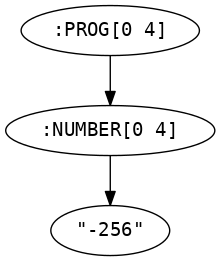

In [4]:
(instaparse.core/visualize (const-parser "-256") :output-file :buffered-image )

But this minimal parser fails to parse strings that we would want to consider valid :

In [5]:
(prn (const-parser "    -123456    "))

Parse error at line 1, column 1:
    -123456    
^
Expected:
#"-?[0-9]+" (followed by end-of-string)



null

As we want to handle spaces before and after the number, we have to modify the grammar accordingly. For efficiency reasons, we also handle the plurality of consecutive spaces at the lexing stage with a regular expression :

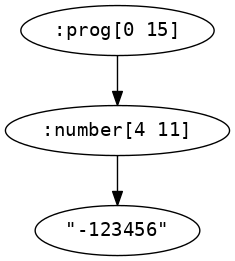

In [6]:
(def const-parser
  (instaparse.core/parser
   "prog= spaces number spaces
    number=#'-?[0-9]+'
    <spaces> = <#'[ ]'*>"))
    
(instaparse.core/visualize (const-parser "    -123456    ") :output-file :buffered-image )

Exercice : What if we remove the angle brackets in the grammar rules ?

## **const** interpreter

The simplest interpreter would be something like :

In [7]:
 (defn const-interpreter [ast]
   (instaparse.core/transform {:number #(Long/parseLong %)} ast))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-interpreter

In [8]:
 (prn (-> "-123" const-parser const-interpreter))

[:prog -123]


null

However, as we will want reuse code between the various languages, we will
separate the language specific transform map and a generic function to turn an
AST into a clojure function.

The generic function taking a transform map and returning the function turning an
AST into a clojure function : 

In [9]:
(defn dynamic-eval [interpreter]
    (fn[ast]
      (fn[]
        (instaparse.core/transform interpreter ast))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/dynamic-eval

We can use this function for our **const** language to create a `const-eval`
function that will turn an AST into a clojure function:

In [10]:
(def const-interpreting
  {:prog identity
   :number #(Long/parseLong %)})
(def const-eval (dynamic-eval const-interpreting))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-eval

This function can be called on the result of parsing a string :

In [11]:
(def const-eval-test (-> "-123 " const-parser const-eval))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-eval-test

The result can then be called like any other clojure function :

In [12]:
(const-eval-test)

-123

## const compiler
The compiler will be implemented in two steps :
- turning the AST into a sequence of vectors. Each vector representing a
  bytecode instruction and the parameters, if any, of the instruction.
- generating a class with a static method implementing the bytecodes sequence
  , dynamically loading this class and returning a clojure function calling the static method of the generated
  class.


###  Generating the instructions sequence
As we will be processing an AST, we can do this with a transform map :

In [13]:
(def const-compiling
  {:prog (fn[& instrs](conj (reduce into [[:loadi 0]] instrs)[:reti]))
   :number #(vector [:loadi (Long/parseLong %)])})

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-compiling

The first `[:loadi 0]` will be useful when we allow empty programs : we will
then always have a 0 on the stack, to return if nothing has been put on the
stack by the program.

In [14]:
(prn (->> "-123" const-parser (instaparse.core/transform const-compiling)))

[[:loadi 0] [:loadi -123] [:reti]]


null

The actual bytecode will be generated by reducing a function over our sequence
of bytecode instructions, calling the relevant method from a [MethodVisitor](http://asm.ow2.org/asm50/javadoc/user/org/objectweb/asm/MethodVisitor.html)
object. The simplest way to implement it is the following :

In [15]:
  (import '(clojure.asm Opcodes Type ClassWriter))
  (import '(clojure.asm.commons Method GeneratorAdapter))

class clojure.asm.commons.GeneratorAdapter

In [16]:
(defn const-instr-generating [mv instr]
  "Generate the method call to an  org.objectweb.asm.MethodVisitor for a given instruction."
  (do
    (condp = (first instr)
        :loadi (.visitLdcInsn mv (int (second instr)))
        :reti (.visitInsn mv Opcodes/IRETURN)
        )
  mv))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-instr-generating

A `compiled` function will take care of creating class with a given class name,
generating the bytecode in a static method called `run` and returning a clojure
function calling the static method. We will be forward thinking by taking a
number of arguments as a parameter, even if this argument will be 0 for all of
our languages until **lang1**. The `bytecode-generator` will be a function calling
the reducing function over the sequence of bytecode instructions, taking the
`MethodVisitor` as argument :


In [17]:
(defn compiled [n-args class-name bytecode-generator]
    (let [cw (ClassWriter. (+ ClassWriter/COMPUTE_FRAMES ClassWriter/COMPUTE_MAXS ))
          init (Method/getMethod "void <init>()")
          meth-name "run"
          meth-sig (str "(" (apply str (repeat n-args "I")) ")I")]
      (.visit cw Opcodes/V1_6 Opcodes/ACC_PUBLIC (.replace class-name \. \/) nil "java/lang/Object" nil)
      (doto (GeneratorAdapter. Opcodes/ACC_PUBLIC init nil nil cw)
        (.visitCode)
        (.loadThis)
        (.invokeConstructor (Type/getType Object) init)
        (.returnValue)
        (.endMethod))
      (doto (.visitMethod cw (+ Opcodes/ACC_PUBLIC Opcodes/ACC_STATIC) meth-name meth-sig nil nil )
        (.visitCode)
        (bytecode-generator)
        (.visitMaxs 0 0 )
        (.visitEnd))
      (.visitEnd cw)
      (let [b (.toByteArray cw)
            cl (clojure.lang.DynamicClassLoader.)]
        (.defineClass cl class-name b nil))
      (fn [& args] (clojure.lang.Reflector/invokeStaticMethod class-name meth-name (into-array args))))
    )


#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/compiled

It can be used in a `bytecode-generating-eval` function to create a compiler
that will take an ast as argument and return the function created with `compiled` :

In [18]:
(defn bytecode-generating-eval [n-args class-name compiling instr-generating]
  (fn[ast]
  (let[instrs (instaparse.core/transform compiling ast)
       generate-prog (fn[mv] (reduce instr-generating mv instrs))]
    (compiled n-args class-name generate-prog))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/bytecode-generating-eval

Using this function for our **const** language would be :

In [19]:
(def const-compiler (bytecode-generating-eval 0 "ConstCompiler" const-compiling const-instr-generating))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-compiler

Such a compiler can then be used like :

In [20]:
(def const-compiler-test (-> "-123" const-parser const-compiler ))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/const-compiler-test

And the resulting function is a normal clojure function :

In [21]:
(const-compiler-test)

-123

#### Improving the instructions generating reducing function
The `const-instr-generating` function defined above works perfectly fine. In
order to define other languages, we could just replace it with new functions
adding cases to the `condp` expression. However, it can also be rewritten to be
_extended_ rather than replaced, by using dynamic dispatching on the instruction
type. This can easily be done in clojure with a *multimethod*. A dispatching
implementation could use a `generate-instr` multimethod :


In [22]:
(defmulti generate-instr (fn [mv [instr & args]] instr))
(defn dispatching-bytecode-generating-eval [n-args class-name compiling]
  (fn[ast]
    (let[instrs (instaparse.core/transform compiling ast)
         generate-prog (fn[mv] (reduce generate-instr mv instrs))]
      (compiled n-args class-name generate-prog))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/dispatching-bytecode-generating-eval

The `generate-instr` multimethod is defined as dispatching according to the
value of the first element of the vector argument (which will be the keyword
indicating the kind of bytecode instruction).
For our **const** language, we only need two implementation mirroring the two
cases of the `condp` in `const-instr-generating` :

In [23]:
(defmethod generate-instr :loadi [mv [instr & args]]
  (doto mv
    (.visitLdcInsn (int (first args)))))

(defmethod generate-instr :reti [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/IRETURN)))

clojure.lang.MultiFn@6b366a13

The new implementation is called exactly in the same way :

In [24]:
(def const-compiler (dispatching-bytecode-generating-eval 0 "ConstCompiler" const-compiling))
(def const-compiler-test (-> "-123" const-parser const-compiler))
(const-compiler-test)

-123

# AddSub language

## Parser

We define an `add-sub` rule with the foresight that it will be useful to
represent operations of a given priority for the parsing step. However, we do
not need such a node in our AST so we use angle brackets "<>" to remove them for
the resulting AST :

In [25]:
(def addsub-parser
  (instaparse.core/parser
   "prog= spaces add-sub spaces
    <add-sub>= number | add | sub
    add= add-sub spaces <'+'> spaces number
    sub= add-sub spaces <'-'> spaces number
    number= #'-?[0-9]+'
    <spaces>= <#'\\s*'>"))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addsub-parser

The parser can be used on a sample string :

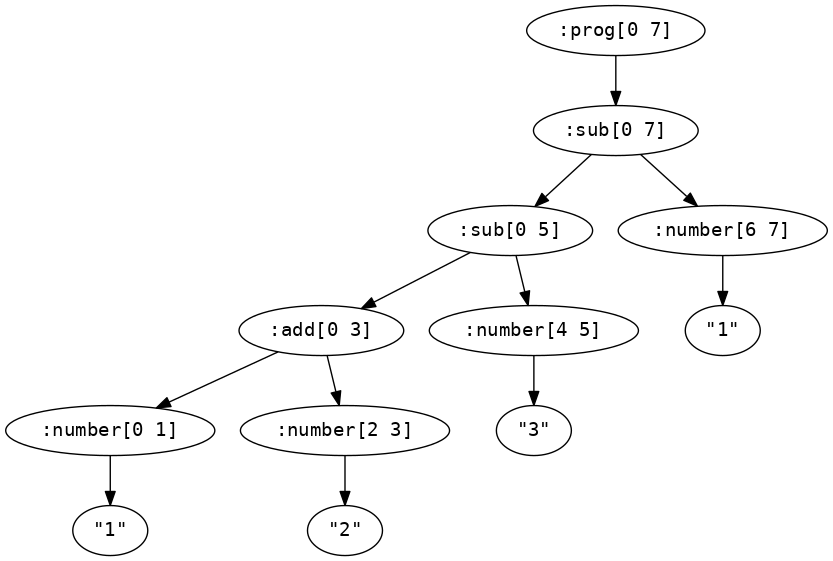

In [26]:
(-> "1+2-3-1" addsub-parser (instaparse.core/visualize :output-file :buffered-image ))

## Interpreter

We can define our interpreting transform map by adding the functions to process
the new `:add` and `:sub` nodes in the AST :

In [27]:
(def addsub-interpreting
  (assoc const-interpreting :add + :sub -))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addsub-interpreting

We can then reuse our previous functions :

In [28]:
(def addsub-eval (dynamic-eval addsub-interpreting))
(def addsub-eval-test (-> "1+2-3-1" addsub-parser addsub-eval))
(addsub-eval-test)

-1

## Compiler

The bytecode sequence for a binary operation is the concatenation of the
bytecode sequence for the first operand, the bytecode sequence for the second
operand, and the specific bytecode for the given operation. We define a function
`assoc-binary-op` to add such function to a transform map turning an AST into a
sequence of bytecode instructions. The `op` argument is the AST node and the
`instr` argument is the keyword representing bytecode instruction :


In [29]:
(defn assoc-binary-op [m [op instr]]
  (let[binary-op-compiling (fn[op]
                             (fn[instrs-v0 instrs-v1]
         (conj (into instrs-v0 instrs-v1) [op])))]
    (assoc m op (binary-op-compiling instr))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/assoc-binary-op

We can use it to create our `addsub` transform map :

In [30]:
(def addsub-compiling
  (reduce assoc-binary-op const-compiling [[:add :addi][:sub :subi]]))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addsub-compiling

We can test it :

In [31]:
(str (->> "1+2-3-1" addsub-parser (instaparse.core/transform addsub-compiling)))

[[:loadi 0] [:loadi 1] [:loadi 2] [:addi] [:loadi 3] [:subi] [:loadi 1] [:subi] [:reti]]

We just have to add the multimethod definitions for the new instructions :

In [32]:
(defmethod generate-instr :addi [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/IADD)))

(defmethod generate-instr :subi [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/ISUB)))

clojure.lang.MultiFn@6b366a13

The **addsub** compiler can then be created reusing our previous functions :

In [33]:
(def addsub-compiler (dispatching-bytecode-generating-eval 0 "AddsubCompiler" addsub-compiling))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addsub-compiler

We can use it as usual :

In [34]:
(def addsub-compiler-test (-> "1+ 2 - 3 - 1" addsub-parser addsub-compiler))
(addsub-compiler-test)

-1

# Addmult language
## Parser
As we define a top down parser, we first try to match the lowest priority expressions :

In [35]:
(def addmult-parser
  (instaparse.core/parser
   "prog= spaces add-sub spaces
    <add-sub>= mult-div | add | sub
    add= add-sub spaces <'+'> spaces mult-div
    sub= add-sub spaces <'-'> spaces mult-div
    <mult-div>= number | mult | div
    mult= mult-div spaces <'*'> spaces number
    div= mult-div spaces <'/'> spaces number
    number= #'-?[0-9]+'
    <spaces>= <#'\\s*'>"))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addmult-parser

We can use this parser on a sample program :

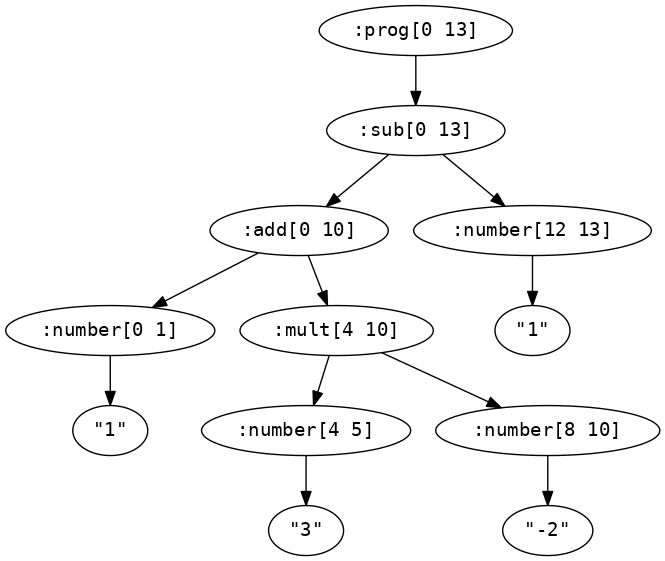

In [36]:
(-> "1 + 3 * -2 -1" addmult-parser (instaparse.core/visualize :output-file :buffered-image ))

## Interpreter
We can add the new AST node types to the transform map :

In [37]:
(def addmult-interpreting (assoc addsub-interpreting :mult * :div /))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addmult-interpreting

And reuse our previous functions :

In [38]:
(def addmult-eval (dynamic-eval addmult-interpreting ))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addmult-eval

The interpreter can be used as usual :

In [39]:
(def addmult-eval-test (-> "1 + 3 * -2 -1" addmult-parser addmult-eval))
(addmult-eval-test)

-6

## Compiler
We can easily add the two new binary operations :

In [40]:
(def addmult-compiling
  (reduce assoc-binary-op addsub-compiling [[:mult :multi][:div :divi]]))

(defmethod generate-instr :multi [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/IMUL)))

(defmethod generate-instr :divi [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/IDIV)))

clojure.lang.MultiFn@6b366a13

And then reuse the previous functions :

In [41]:
(def addmult-compiler (dispatching-bytecode-generating-eval 0 "AddmultCompiler" addmult-compiling))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/addmult-compiler

This compiler can be used as usual :

In [42]:
(def addmult-compiler-test (-> "1 + 3 * -2 - 1" addmult-parser addmult-compiler))
(addmult-compiler-test)

-6

# Arith language
## Parser
We can update our grammar to allow grouping by matching parentheses. This is done by introducing a high priority `factor` that can be either a `number` or an expresssion (lowest level : `add-sub`) between parentheses :

In [43]:
(def arith-parser
  (instaparse.core/parser
   "prog = spaces add-sub spaces
    <add-sub> = mult-div | add | sub
    add = add-sub spaces <'+'> spaces mult-div
    sub = add-sub spaces <'-'> spaces mult-div
    <mult-div> = term | mult | div
    mult = mult-div spaces <'*'> spaces term
    div = mult-div spaces <'/'> spaces term
    <term> = number | <'('> add-sub <')'>
    <spaces> = <#'\\s'*>
    number = #'-?[0-9]+'"))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/arith-parser

We can use this grammar on a sample program :

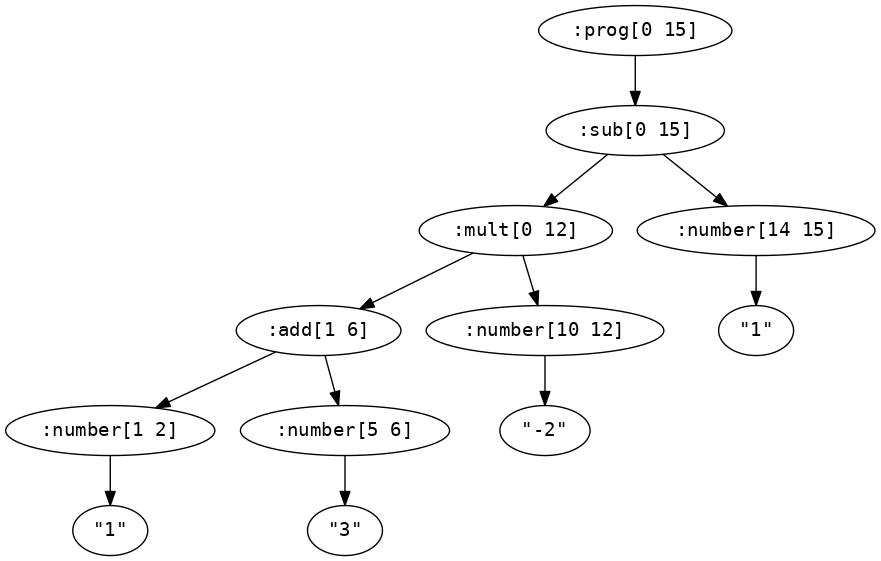

In [44]:
(-> "(1 + 3) * -2 -1" arith-parser (instaparse.core/visualize :output-file :buffered-image ))

 ## Interpreter
 The AST containts exactly the same kind of nodes as for the **addmult** language (neither the new `(` and `)` symbols nor the new `term` rule produce any node), so the interpreter is exactly the same:

In [45]:
(def arith-eval-test (-> "(1 + 3) * -2 -1" arith-parser addmult-eval))
(arith-eval-test)

-9

For exactly the same reason, the compiler is exactly the same as the **addmult** compiler:

In [46]:
(def arith-compiler-test (-> "1 + 3 * (-2 - 1)" arith-parser addmult-compiler))
(arith-compiler-test)

-8

# Lang0
## Parser
We update the parser to define :
- a program as a sequence of expressions
- an expression that can be either an assignment or an arithmetic expression
- variables that can either be used on the left hand side of an assignment or as a read ("varget") on the right hand side
- factor that replaces term and also allows for `varget` or assignments (the value of the assignment expression is the assigned value)

In [47]:
(def lang0-parser
  (instaparse.core/parser
   "prog = (spaces expr spaces <';'> spaces)*
    <expr> = assig | add-sub
    assig = varname spaces <'='> spaces expr
    <add-sub> = mult-div | add | sub
    add = add-sub spaces <'+'> spaces mult-div
    sub = add-sub spaces <'-'> spaces mult-div
    <mult-div> = factor | mult |div
    mult = mult-div spaces <'*'> spaces factor
    div = mult-div spaces <'/'> spaces factor
    <factor> = number | <'('> spaces expr spaces <')'> | varget |assig
    <spaces> = <#'\\s*'>
    number = #'-?[0-9]+'
    varget = varname
    varname = #'[a-zA-Z]\\w*'"))


#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang0-parser

The parser can be used on a sample program :

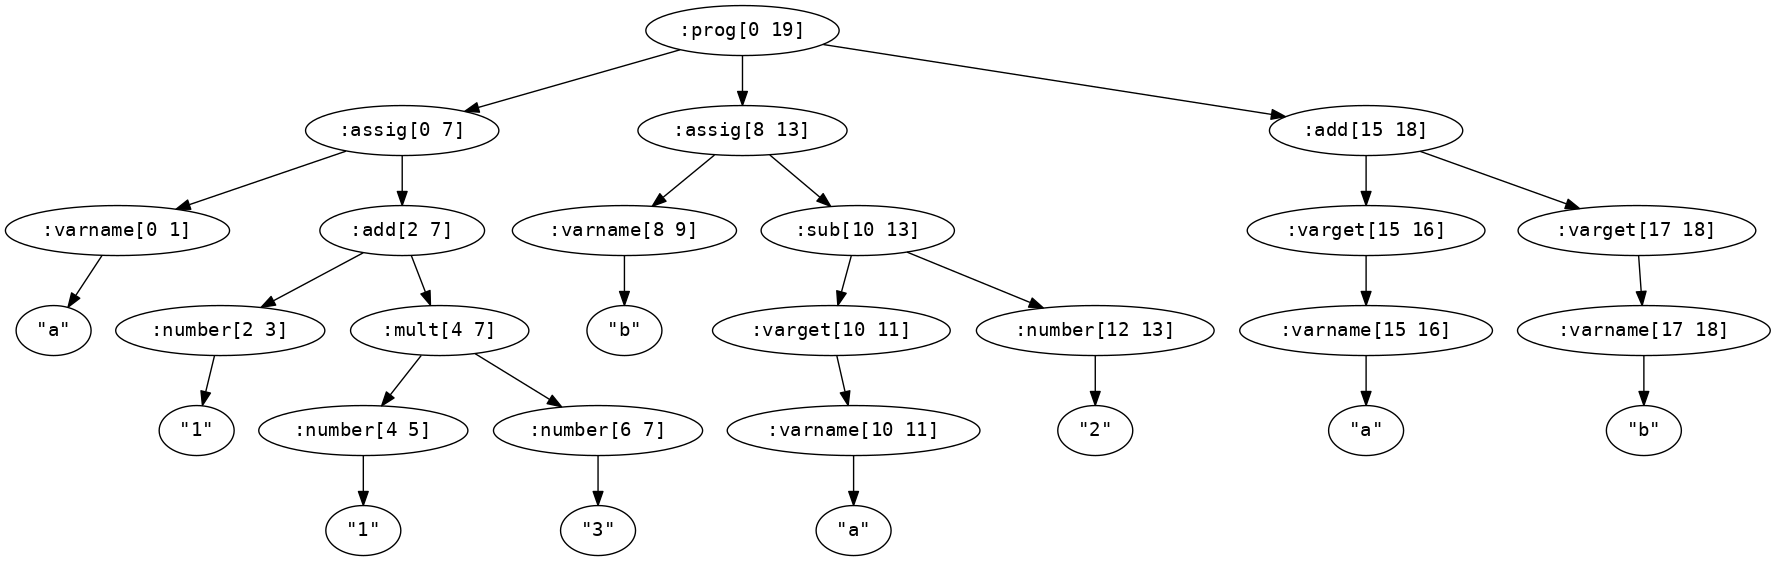

In [48]:
(-> "a=1+1*3;b=a-2; a+b;" lang0-parser (instaparse.core/visualize :output-file :buffered-image ))

## Interpreter

Now, our interpreter must be able to access an environment, so that assignments
can have an effect. This environment is a map, mapping from variable names (as
keywords) to values, with a special key `:_ret` for the current value of an
expression. When evaluating the nodes of an AST with a transform map, each node
will evaluate to the new environment. The first transform map just reduces the actual
transform map over the environment :

In [49]:
(defn make-interpreting [make-instr-interpreting init-env]
  {:prog (fn [& instrs] (:_ret (reduce
                                       (fn[env instr]
                                         (instaparse.core/transform (make-instr-interpreting env) instr))
                                       init-env
                                       instrs)))})
(defn make-lang0-instr-interpreting [env]
  { :assig (fn[{varname :_ret :as env1} {value :_ret :as env2}]
             (assoc (merge env1 env2) varname value :_ret value))
   :add (fn[{v1 :_ret :as env1} {v2 :_ret :as env2}]
          (assoc (merge env1 env2) :_ret (+ v1 v2)))
   :sub (fn[{v1 :_ret :as env1} {v2 :_ret :as env2}]
          (assoc (merge env1 env2) :_ret (- v1 v2)))
   :mult (fn[{v1 :_ret :as env1} {v2 :_ret :as env2}]
           (assoc (merge env1 env2) :_ret (* v1 v2)))
   :div (fn[{v1 :_ret :as env1} {v2 :_ret :as env2}]
          (assoc (merge env1 env2) :_ret (quot v1 v2)))
   :number #(assoc env :_ret (Integer/parseInt %))
   :varname #(assoc env :_ret (keyword %))
   :varget (fn [{varname :_ret :as env1}]
             (assoc env1 :_ret (varname env1)))})


#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/make-lang0-instr-interpreting

We can reuse the previous functions :

In [50]:
(def lang0-interpret (dynamic-eval (make-interpreting make-lang0-instr-interpreting {:_ret 0})))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang0-interpret

And test our interpreter as usual:

In [51]:
(def lang0-interpret-test (->> "a=1+1*3;b=a-2; a+b;" lang0-parser lang0-interpret))
(lang0-interpret-test)

6

## Compiler
We update the transform map :

In [52]:
(def lang0-compiling
  (assoc addmult-compiling
         :varget #(vector [:load %])
         :assig (fn[var instrs](conj instrs [:store var]))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang0-compiling

But we also have to replace variable names with numbers (the JVM bytecode numbers arguments and local variables in the order they appear in a method). We are forward thinking by taking a =nb-args= argument even if for now we will
number our variables starting with 0.

In [53]:
(use 'clojure.set)
;; helper function that replaces all the values in map m with the given value v
(defn replace-vals [m v]
  (into {} (map vector (keys m) (repeat v ))))

(defn to-numeric-vars[nb-args ast]
  (let[varnames
       (instaparse.core/transform
        (assoc (replace-vals
                lang0-compiling
                (fn[& instrs] (apply clojure.set/union (filter set? instrs))))
               :varname (fn[varname]#{varname}))
        ast)
       name->num (into {} (map vector varnames (iterate inc nb-args)))]
    (instaparse.core/transform {:varname #(get name->num %)} ast)))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/to-numeric-vars

We can test this helper function :

In [54]:
(str (->> "a=1+1*3;b=a-2; a+b;" lang0-parser (to-numeric-vars 0)))

[:prog [:assig 0 [:add [:number "1"] [:mult [:number "1"] [:number "3"]]]] [:assig 1 [:sub [:varget 0] [:number "2"]]] [:add [:varget 0] [:varget 1]]]

And see how it works when called before compiling to bytecode representation :

In [55]:
(str (->> "a=1+1*3;b=a-2; a+b;" lang0-parser (to-numeric-vars 0) (instaparse.core/transform lang0-compiling)))

[[:loadi 0] [:loadi 1] [:loadi 1] [:loadi 3] [:multi] [:addi] [:store 0] [:load 0] [:loadi 2] [:subi] [:store 1] [:load 0] [:load 1] [:addi] [:reti]]

We also have to provide the new implementations for the `generate-instr` multimethod.
For the assignment, we first duplicate the value at the top of the stack (that
will be assigned) so that it will still be there after the assignment (`store`
instruction). This enables us to use assignments as expressions : the value of
the assignment expression is the assigned value.

In [56]:
(defmethod generate-instr :load [mv [instr & args]]
  (doto mv
    (.visitVarInsn Opcodes/ILOAD (int (first args)))))

(defmethod generate-instr :store [mv [instr & args]]
  (doto mv
    (.visitInsn Opcodes/DUP)
    (.visitVarInsn Opcodes/ISTORE (int (first args)))))

clojure.lang.MultiFn@6b366a13

We can then reuse our previous functions :

In [57]:
(def lang0-compiler (dispatching-bytecode-generating-eval 0 "Lang0Compiler" lang0-compiling))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang0-compiler

And test our compiler as usual :

In [58]:
(def lang0-compiler-test (->> "a=1 + 3 * (-2 - 1);b= 0 - a;" lang0-parser (to-numeric-vars 0) lang0-compiler))
(lang0-compiler-test)

8

# Lang1
## Parser
We just add arguments as a special kind of variables in the `varget` rule, their names begin of the form "%0", "%1",…

In [59]:
(def lang1-parser
  (instaparse.core/parser
   "prog = (spaces expr spaces <';'> spaces)*
      <expr> = assig | add-sub
      assig = varname spaces <'='> spaces expr
      <add-sub> = mult-div | add | sub
      add = add-sub spaces <'+'> spaces mult-div
      sub = add-sub spaces <'-'> spaces mult-div
      <mult-div> = factor | mult |div
      mult = mult-div spaces <'*'> spaces factor
      div = mult-div spaces <'/'> spaces factor
      <factor> = number | <'('> spaces expr spaces <')'> | varget |assig
      <spaces> = <#'\\s*'>
      number = #'-?[0-9]+'
      varget = varname | argument
      varname = #'[a-zA-Z]\\w*'
      argument= <'%'>#'[0-9]+'"))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang1-parser

We can test this parser on a sample program :

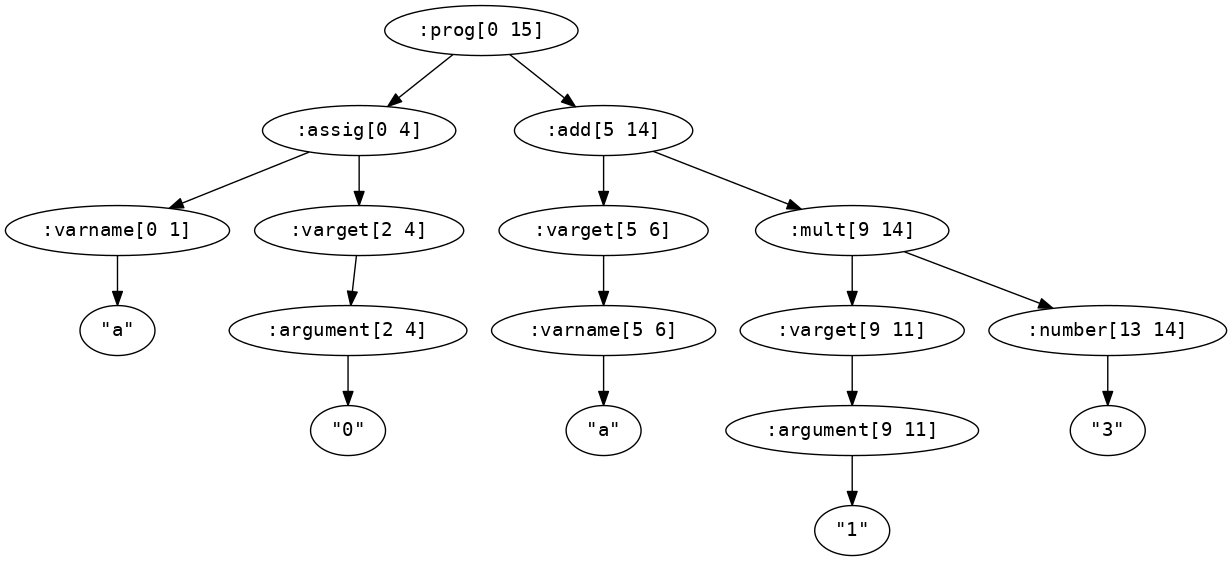

In [60]:
(-> "a=%0;a + %1 *3;" lang1-parser (instaparse.core/visualize :output-file :buffered-image ))

## Interpreter
Instead of starting with an empty environment, we fill the initial environment
with arguments :

In [61]:
(defn args-to-env[args]
  (into {} (map-indexed #(vector (keyword (str "%" %1)) %2) args)))

(defn dynamic-eval-args [make-interpreter]
  (fn[ast]
    (fn[& args]
      (instaparse.core/transform (make-interpreting make-interpreter
                                          (assoc (args-to-env args)
                                                 :_ret 0))
                       ast))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/dynamic-eval-args

We can easily update the transform map from **lang0** :

In [62]:
(defn make-lang1-instr-interpreting [env]
  (assoc (make-lang0-instr-interpreting env)
         :argument #(assoc env :_ret (keyword (str "%" %)))))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/make-lang1-instr-interpreting

And define our interpreter :

In [63]:
(def lang1-interpret (dynamic-eval-args make-lang1-instr-interpreting))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang1-interpret

The interpreter can be called as usual, except that now we can pass arguments to our function when we call it :

In [64]:
(def lang1-interpret-test (->> "a=%0;a + %1 *3;" lang1-parser lang1-interpret))
(lang1-interpret-test 2 3)

11

## Compiler
In order to implement the compiler, we will first have to be able to know how
many arguments are used in a program. This can be easily done with a transform
map :

In [65]:
(defn nb-args[ast]
  (inc (instaparse.core/transform (assoc (replace-vals
                           lang0-compiling (fn[& args]
                                             (apply max (conj (filter number? args)
                                                              -1))))
                          :argument #(Integer/parseInt %))
                   ast)))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/nb-args

We can test this function :

In [66]:
(->> "a=%0;a + %1 *3;" lang1-parser nb-args)

2

Then we add an AST transformation step to replace the `:argument` nodes with the
value of the argument number:

In [67]:
(defn args->varnum[ast]
  (instaparse.core/transform {:argument #(Integer/parseInt %)} ast))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/args->varnum

As a few steps in the compilation chain will depend on the number of arguments,
we define a new function instead of just piping our AST through the various
stages :

In [68]:
(defn lang1-compiler-chain[class-name ast]
  (let[n-args (nb-args ast)
       compiler (dispatching-bytecode-generating-eval n-args class-name lang0-compiling)]
    (->> ast args->varnum (to-numeric-vars n-args) compiler)))

#'beaker_clojure_shell_4f789a8e-b6ba-4007-bb3d-461d7e03438f/lang1-compiler-chain

We can then use this function after parsing as follows :

In [69]:
(def lang1-compiler-test (->> "a=%0;a + %1 *3;" lang1-parser (lang1-compiler-chain "Lang1Compiler")))
(lang1-compiler-test 2 5)

17

## TODO use EasyForm for interactive interpreting and compiling

In [70]:
(def form (doto (com.twosigma.beakerx.easyform.EasyForm. "Test Form")
                (.addTextField "Name")
                (.addButton "Reverse" "reverse")))
form

In [71]:
(reverse (get form "Name"))

[]

## TODO use slider for arg values

In [72]:
%import com.twosigma.beakerx.widget.IntSlider

In [73]:
(new IntSlider)

## TODO benchmark

In [74]:
%%timeit -r30 -n10
(lang1-interpret-test 2 5)

596 µs ± 2 ms per loop (mean ± std. dev. of 30 run, 10 loop each)


In [75]:
%%timeit -r30 -n10
(lang1-compiler-test 2 5)

264 µs ± 1 ms per loop (mean ± std. dev. of 30 run, 10 loop each)


# TODO more powerful JVM bytecode manipulatio
use [a real clojure JVM bytecode library](https://github.com/jgpc42/insn)